# Characterize CTD Rosette-Mounted LISST Data

Load data from Raw Data Archive Cruise Data for Pioneer MAB cruises:
 * <a>https://rawdata.oceanobservatories.org/files/cruise_data/Pioneer-MAB/Pioneer-21_AR87_2025-03-28/LISST/</a>

Separate upcast from downcast data. Compare optical transmission. Also include dashed lines around LISST suspect span (per Sequoia manual). Compare profiles of optical transmission and total volume concentration between casts across distance and time.

## Import libraries

In [1]:
# Import libraries used in this notebook
import os
import re
import glob
import urllib.request as request

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean as cmo
import scipy.signal as signal

## Load data

Including parsing.

In [2]:
# Load LISST CSV column names from json containing column headers
headers = pd.read_json("./inst_headers/lisst_hdr.json", typ='series', orient='records')
csvhdr = headers.iloc[0]
# aschdr = headers.iloc[1] # CTD cast data headers for .asc files

In [ ]:
# Define functions
def load_live_data(testname, csvhdr, testnum=1):
    # Define paths to data
    lisst_path = "C:/Users/kylene.cooley/Documents/prtsz_bench_test"
    live_data_path = f"{testname}_livedata_{testnum}.csv"
    # Load LISST data processed with onboard clean water background
    f = path.join(lisst_path, live_data_path)
    lisst_live = pd.read_csv(f, names=csvhdr)
    try: print(lisst_live.head(1)) 
    except: print("No {testname} LISST data")
    return lisst_live

In [ ]:
# Write function to load PRTSZ total volume concentration from file name
# [WE WILL WANT TO CHANGE THIS TO PROVIDE FULL DATASET]
def load_prtsz_volume_concentration(prtsz_file):
    """ Import PRTSZ data from CSV, use date and time
    columns to create Pandas datetime Index, and define
    Xarray Data Array object containing total volume
    concentration time series.
    Author: Kylene Cooley, 19 Apr 2024
    Inputs:
    -------
    prtsz_file, str of file name in local PRTSZ along shelf CTD 
        survey data directory
    Returns:
    --------
    vol_con, Data Array of total volume concentration from PRTSZ
        dataset with 1 dim = "time"
    """
    # Define path to locally saved PRTSZ data from CN site
    prtsz_path = os.path.join(os.path.expanduser(
    "~/Desktop/pioneer-20_data/PRTSZ_on_rosette/AR82b_CTDsurvey_processed_data/"),
    prtsz_file)
    # Import csv file using pandas and define variables
    prtsz_data = pd.read_csv(prtsz_path, header=None)
    total_vol_concentration = prtsz_data[50]
    year = prtsz_data[42]
    month = prtsz_data[43]
    day = prtsz_data[44]
    hour = prtsz_data[45]
    minute = prtsz_data[46]
    second = prtsz_data[47]
    # Convert time parameter series to datetime vector
    dt_df = pd.DataFrame({"year": year, "month": month,
                        "day": day, "hour": hour,
                        "minute": minute, "second": second})
    prtsz_dt = pd.to_datetime(dt_df,
                            yearfirst=True, utc=True)
    # Create data array of total volume concentration with series
    vol_con = xr.DataArray(data=total_vol_concentration.astype(float),
                            coords={"time": prtsz_dt},
                            name="total_volume_concentration")
    return vol_con

In [12]:
# Define functions and constants
# Base url for data on Raw Data Archive
RDA_URL = "https://rawdata.oceanobservatories.org/files/cruise_data/Pioneer-MAB/Pioneer-21_AR87_2025-03-28/LISST/"
LISST_LOCAL = ""

# General LISST data download and parsing into dataset
def load_lisst(lisst_path, header):
    # Load LISST data from CSV
    lisst_df = pd.read_csv(lisst_path, names=header)
    try: lisst_df.head(1)
    except: print("No LISST data downloaded")
    # Create LISST time vector for Dataframe Index
    lisst_time = pd.to_datetime(lisst_df[
        ["year", "month", "day", "hour", "minute", "second"]
        ], yearfirst=True, utc=True)
    lisst_df.insert(0, "time", lisst_time.values)
    lisst_df.set_index("time", drop=True, inplace=True)
    # Convert data frame to Xarray Dataset for easy manipulation
    lisst_ds = xr.Dataset.from_dataframe(lisst_df)
    # Create 2D array for binned volume concentration
    volumecon2D = list([])
    bins = list([])
    for var in lisst_ds.variables:
        if re.search("volumecon[0-9]+", var):
                bins.append(var)
                volumecon2D.append(lisst_ds[var])
    lisst_ds = lisst_ds.drop_vars(bins)
    str2num = lambda x: int(x.replace("volumecon", ""))
    bins = [str2num(x) for x in bins]
    lisst_ds["volume_concentration_2D"] = xr.concat(
        volumecon2D, pd.Index(bins, name="bin")
        )
    lisst_ds["volume_concentration_2D"] = lisst_ds["volume_concentration_2D"].assign_attrs(units="$\mu$L/L")

    # Mask data where depth < 0
    depth_mask = lisst_ds.time[lisst_ds.depth>=0].values
    lisst_ds = lisst_ds.sel(time=depth_mask)
    return lisst_ds

<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\m'
C:\Users\kylene.cooley\AppData\Local\Temp\ipykernel_46372\1723705768.py:33: SyntaxWarning: invalid escape sequence '\m'
  lisst_ds["volume_concentration_2D"] = lisst_ds["volume_concentration_2D"].assign_attrs(units="$\mu$L/L")


In [4]:
# Use the readme file to get CSV file names for each cast
castfiles = {}
filenext = False
text, urlheaders =  request.urlretrieve(RDA_URL+"AR87_LISST_README.txt")
with open(text) as f:
    for x in f:
        if "CAST" in x:
            # print(x)
            cast = x.replace("    ", "")[:-1]
            filenext = True
            continue
        if (filenext is True)&(".CSV" in x):
            # print(x)
            file = x.replace("    ", "")[:-1]
            castfiles[cast] = file
            filenext = False
        else:
            continue
# castfiles

In [5]:
# Load data with dict values
# for key, value in castfiles:
pairs = list(castfiles.items())
key, value = pairs[0]
print(key)
print(value)
pairs


AR87a_CAST001_L6
I0872156.CSV


[('AR87a_CAST001_L6', 'I0872156.CSV'),
 ('AR87a_CAST002_L8', 'I0872333.CSV'),
 ('AR87a_CAST003_L10', 'I0880110.CSV'),
 ('AR87a_CAST004_GL564_GL376', 'I0891841.CSV'),
 ('AR87a_CAST005_SO', 'I0900037.CSV'),
 ('AR87a_CAST006_SE', 'I0901430.CSV'),
 ('AR87a_CAST007_SE', 'I0901520.CSV'),
 ('AR87a_CAST008_GL339', 'I0912227.CSV'),
 ('AR87a_CAST009_GL514', 'I0920038.CSV'),
 ('AR87a_CAST010_CN', 'I0921428.CSV'),
 ('AR87a_CAST011_NO', 'I0922157.CSV'),
 ('AR87a_CAST012_AC1', 'I0931910.CSV'),
 ('AR87a_CAST013_AL1', 'I0932358.CSV'),
 ('AR87a_CAST014_NO', 'I0940236.CSV'),
 ('AR87a_CAST015_AS1', 'I0940328.CSV'),
 ('AR87a_CAST016_AS2', 'I0940423.CSV'),
 ('AR87a_CAST017_EA', 'I0940519.CSV'),
 ('AR87a_CAST018_AS3', 'I0940917.CSV'),
 ('AR87a_CAST019_AS4', 'I0941043.CSV'),
 ('AR87a_CAST020_SO', 'I0941220.CSV'),
 ('AR87a_CAST021_AC4', 'I0941856.CSV'),
 ('AR87a_CAST022_AL7', 'I0942309.CSV'),
 ('AR87a_CAST023_GL1145', 'I0950113.CSV'),
 ('AR87b_CAST002_L6', 'I1002135.CSV'),
 ('AR87b_CAST003_L8', 'I1002312.CSV'

In [13]:
# Load one dataset using RDA URL
lisst_path = RDA_URL + value
lisst_ds = load_lisst(lisst_path, csvhdr)

# Add dataset attribute with cast name string
lisst_ds = lisst_ds.assign_attrs(cast=key)
lisst_ds


<xarray.Dataset> Size: 182kB
Dimensions:                  (time: 366, bin: 36)
Coordinates:
  * time                     (time) datetime64[ns] 3kB 2025-03-28T21:59:42 .....
  * bin                      (bin) int64 288B 1 2 3 4 5 6 ... 31 32 33 34 35 36
Data variables: (12/26)
    laser_transmission       (time) float64 3kB 0.9978 0.9777 ... 0.9047 0.8972
    supply_voltage           (time) float64 3kB 10.64 10.66 ... 10.58 10.58
    ext_in1                  (time) int64 3kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    laser_ref                (time) float64 3kB 1.055 1.055 ... 0.9505 0.9495
    depth                    (time) float64 3kB 0.16 1.35 1.09 ... 0.01 0.24
    temperature              (time) float64 3kB 6.177 5.746 ... 5.183 5.184
    ...                       ...
    rawpressure2             (time) int64 3kB 22559 22746 22705 ... 22536 22572
    ambient_light            (time) int64 3kB 4 3 3 3 4 3 3 3 ... 5 4 6 5 6 7 7
    ext_in3                  (time) float64 3kB 1.722 1.264 1.77 ... 1.438 1.495
    optical_transmission     (time) float64 3kB 0.97 0.951 0.964 ... 0.976 0.969
    beam_attenuation         (time) float64 3kB 1.212 2.027 ... 0.972 1.266
    volume_concentration_2D  (bin, time) float64 105kB 0.0 0.0 ... 0.0009 0.0
Attributes:
    cast:     AR87a_CAST001_L6

## Separate key parameters for analysis

In [ ]:
# Split datasets containing multiple casts (first cast aborted, for example)

In [ ]:
# Combine cast data with cast number as a new dimension (goal: simplify plotting)

In [14]:
# Define plotting function
def addprofile2axes(ax, data, variable, color):
    ax.plot(data[variable], data["depth"],
             c=color, label=data.cast)
    plt.legend()
    return ax

## Compare optical transmission data by depth

In [ ]:
# Add multiple cast data to one axes
color = cmocean. # pick a sequential colormap with len = len(pairs)
fig, ax0 = plt.subplots()

# loop through list of files
while len(pairs)>0:
    key, value = pairs.pop()
    lisst_path = RDA_URL + value
    lisst_ds = load_lisst(lisst_path, csvhdr)
    lisst_ds = lisst_ds.assign_attrs(cast=key)
    # Add cast data to existing axes
    ax0 = addprofile2axes(ax0, lisst_ds, "optical_transmission", color)

# Add final figure elements
ax0.invert_yaxis()
ax0.grid()
plt.legend()

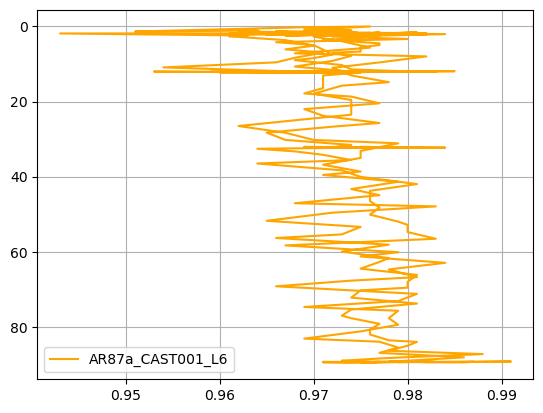

In [28]:
# Test plotting workflow to add cast data to existing axes
color = "orange"
fig, ax0 = plt.subplots()

# Load one dataset using RDA URL
lisst_path = RDA_URL + value
lisst_ds = load_lisst(lisst_path, csvhdr)
# Add dataset attribute with cast name string
lisst_ds = lisst_ds.assign_attrs(cast=key)
# Add plot of a parameter in ds to axes
ax0 = addprofile2axes(ax0, lisst_ds, "optical_transmission", color)

ax0.invert_yaxis()
ax0.grid()
plt.legend()

In [ ]:
# Define plotting function to make similar
# figures given axes and 3 data arrays
def plot_prtsz_comparison(ax1, volume_concentration,
                          beam_transmission, depth):
    midpt = int(len(beam_transmission)/2)
    ax2 = ax1.twiny()
    ax1.plot(volume_concentration[:midpt], depth[:midpt], c="black")
    ax1.plot(volume_concentration[midpt-1:], depth[midpt-1:], "--", c="black", lw=1)
    ax1.invert_yaxis()
    ax1.set_xlabel("Total volume concentration [PPM]")
    ax1.set_ylabel("Depth [m]")
    ax2.plot(beam_transmission[:midpt], depth[:midpt], c="skyblue")
    ax2.plot(beam_transmission[midpt-1:], depth[midpt-1:], "--", c="skyblue", lw=1)
    ax2.set_xlabel("Beam transmission %", color="skyblue")
    return 

## Compare total volume concentration by depth

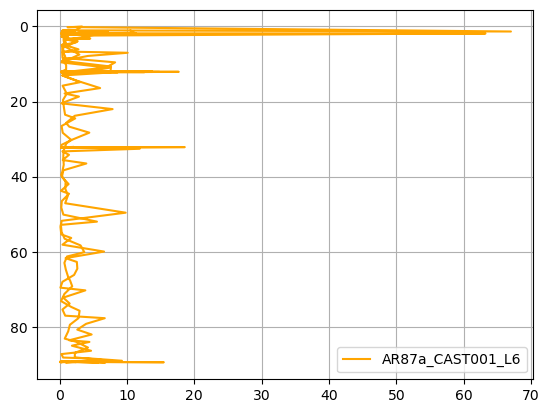

In [27]:
# Test plotting workflow to add cast data to existing axes
color = "orange"
fig, ax1 = plt.subplots()

# Load one dataset using RDA URL
lisst_path = RDA_URL + value
lisst_ds = load_lisst(lisst_path, csvhdr)
# Add dataset attribute with cast name string
lisst_ds = lisst_ds.assign_attrs(cast=key)
# Add plot of a parameter in ds to axes
ax1 = addprofile2axes(ax1, lisst_ds, "total_volumecon", color)

ax1.invert_yaxis()
ax1.grid()
plt.legend()

## Compare reference laser power and temperature

<ul>
    <li>Profiles by depth</li>
    <ul>
        <li>twin x-axes</li>
        <li>subplots side-by-side</li>
    </ul>
    <li>Scatter plot</li>
    <ul>
        <li>with linear regression if there appears to be a relationship</li>
    </ul>
</ul>

C:\Users\kylene.cooley\AppData\Local\Temp\ipykernel_46372\1774034561.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


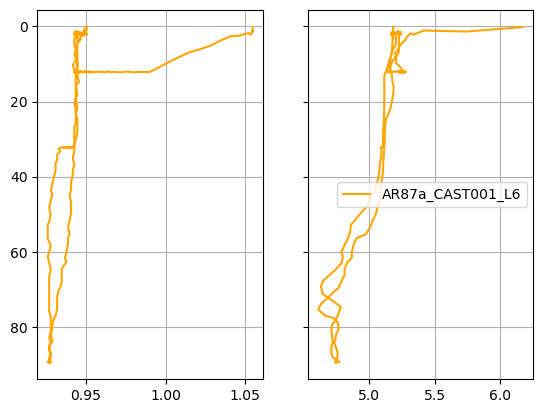

In [ ]:
# Test plotting workflow to add cast data to existing axes
fig, axs2 = plt.subplots(1, 2, sharey=True)
color = "orange"

# Load one dataset using RDA URL
lisst_path = RDA_URL + value
lisst_ds = load_lisst(lisst_path, csvhdr)
# Add dataset attribute with cast name string
lisst_ds = lisst_ds.assign_attrs(cast=key)
# Add plot of parameters in ds to different axes
axs2[0] = addprofile2axes(axs2[0], lisst_ds, "laser_ref", color)
# plt.legend()
# ax3 = plt.twiny(ax2)
axs2[1] = addprofile2axes(axs2[1], lisst_ds, "temperature", color)

axs2[0].invert_yaxis()
axs2[0].grid()
axs2[1].grid()
# plt.legend()

## Compare laser transmission power and temperature

<ul>
    <li>Profiles by depth</li>
    <ul>
        <li>twin x-axes</li>
        <li>subplots side-by-side</li>
    </ul>
    <li>Scatter plot</li>
    <ul>
        <li>with linear regression if there appears to be a relationship</li>
    </ul>
</ul>

C:\Users\kylene.cooley\AppData\Local\Temp\ipykernel_46372\1774034561.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\kylene.cooley\AppData\Local\Temp\ipykernel_46372\2495579503.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


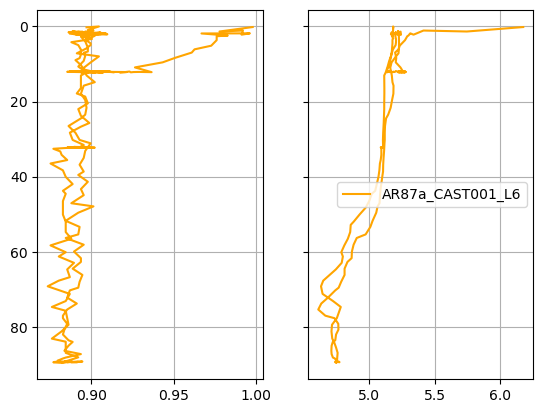

In [25]:
# Test plotting workflow to add cast data to existing axes
fig, axs3 = plt.subplots(1, 2, sharey=True)
color = "orange"

# Load one dataset using RDA URL
lisst_path = RDA_URL + value
lisst_ds = load_lisst(lisst_path, csvhdr)
# Add dataset attribute with cast name string
lisst_ds = lisst_ds.assign_attrs(cast=key)
# Add plot of parameters in ds to different axes
axs3[0] = addprofile2axes(axs3[0], lisst_ds, "laser_transmission", color)
plt.legend()
axs3[1] = addprofile2axes(axs3[1], lisst_ds, "temperature", color)

axs3[0].invert_yaxis()
axs3[0].grid()
axs3[1].grid()
plt.legend()

## Compare ambient light by depth

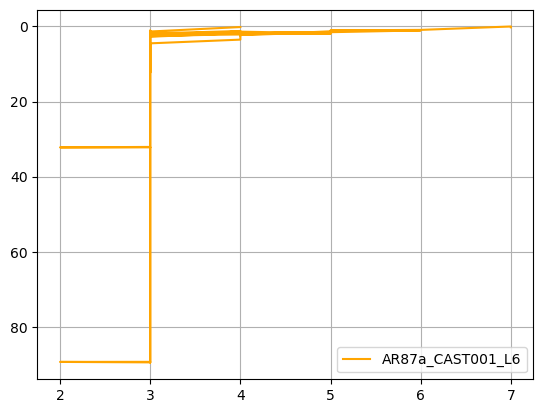

In [ ]:
# Test plotting workflow to add cast data to existing axes
color = "orange"
fig, ax1 = plt.subplots()

# Load one dataset using RDA URL
lisst_path = RDA_URL + value
lisst_ds = load_lisst(lisst_path, csvhdr)
# Add dataset attribute with cast name string
lisst_ds = lisst_ds.assign_attrs(cast=key)
# Add plot of a parameter in ds to axes
ax1 = addprofile2axes(ax1, lisst_ds, "ambient_light", color)

ax1.invert_yaxis()
ax1.grid()
plt.legend()

## Compare mean particle diameter by depth

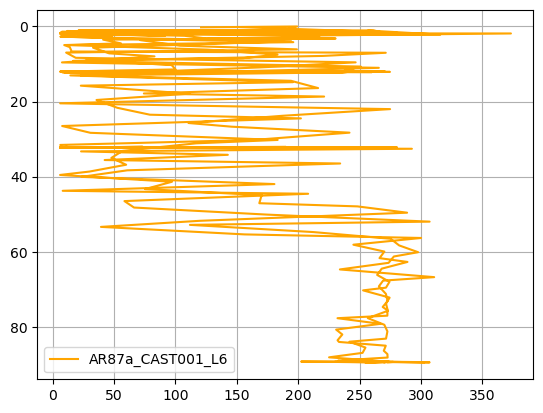

In [ ]:
# Test plotting workflow to add cast data to existing axes
color = "orange"
fig, ax1 = plt.subplots()

# Load one dataset using RDA URL
lisst_path = RDA_URL + value
lisst_ds = load_lisst(lisst_path, csvhdr)
# Add dataset attribute with cast name string
lisst_ds = lisst_ds.assign_attrs(cast=key)
# Add plot of a parameter in ds to axes
ax1 = addprofile2axes(ax1, lisst_ds, "mean_diameter", color)

ax1.invert_yaxis()
ax1.grid()
plt.legend()

In [ ]:
# Plot Welch PSD of mean particle diameter
# TO-DO: add the frequency-space kernel w/ first lobe wide enough to cut off noise
#   FWHM above the parts below 10^-4 level?
f, Pdiameter_density = signal.welch(lisst_ds["mean_diameter"], fs=2)
plt.semilogy(f, Pdiameter_density)

In [ ]:
# Use a time domain filter that will work like the freq-space kernel